<h1>Ecological Consumption and its relationship to GDP</h1>

A country’s ecological assets can have a great impact on what it produces in its economy. For example, countries with abundant natural supplies of oil, distribute oil worldwide and it contributes to most of their economic activity. Because of this, we have decided to investigate whether or not the amount of ecological assets a country has impacts their GDP Per Capita. The question we are trying to answer is: Are ecological assets a good predictor of a country’s GDP Per Capita? The data set we will be using is called “2016 Global Ecological Footprint,” by the Global Footprint Network. This dataset contains information about several countries' ecological footprints, with several observations about their ecological assets such as farmland and urban land. It also has the countries GDP per Capita,  which we will categorize and predict in our model.

In [1]:
# required libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

<h4>Preliminary exploratory data analysis:

In [2]:
# importing untidy data set
countries_raw_data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vR_6ci0B-tyn-2T5ywr5cOSxgtls94IPi3zrpu5z3fNxDyK8R1985IH1Uq3zd253ufZIr8Y1tgxffnq/pub?output=csv")

#the folliwning steps aim to tidy the data set


#renaming columns of interest so that they are underline-separated

names(countries_raw_data)[names(countries_raw_data) == "GDP per Capita"] <- "GDP_per_capita"
names(countries_raw_data)[names(countries_raw_data) == "Cropland Footprint"] <- "cropland_footprint"
names(countries_raw_data)[names(countries_raw_data) == "Grazing Footprint"] <- "grazing_footprint"
names(countries_raw_data)[names(countries_raw_data) == "Forest Footprint"] <- "forest_footprint"
names(countries_raw_data)[names(countries_raw_data) == "Fish Footprint"] <- "fish_footprint"
names(countries_raw_data)[names(countries_raw_data) == "Carbon Footprint"] <- "carbon_footprint"

Parsed with column specification:
cols(
  .default = col_double(),
  Country = col_character(),
  Region = col_character(),
  `GDP per Capita` = col_character(),
  `Data Quality` = col_character()
)

See spec(...) for full column specifications.



In [3]:
# selecting columns of interest from the data frame; includes Country name, GDP per Capit, 
# and ecological footprints of interest to our project
countries_GDP_eco <- countries_raw_data %>% select(Country, GDP_per_capita, cropland_footprint, 
                                                  grazing_footprint, forest_footprint, 
                                                  fish_footprint, carbon_footprint)

# removing any rows that have an NA cell
countries_GDP_eco <- na.omit(countries_GDP_eco)


# removing the "$" sign and "," from all elements of the GDP_per_capita column
countries_GDP_eco <-  countries_GDP_eco %>% 
                         mutate(GDP_per_capita = gsub("[^[:alnum:][:space:].]", "",
                                                      countries_GDP_eco$GDP_per_capita))

# converting GDP_per_capita from a character data type to double

countries_GDP_eco <- countries_GDP_eco %>% mutate(GDP_per_capita = as.numeric(GDP_per_capita))
countries_GDP_eco

Country,GDP_per_capita,cropland_footprint,grazing_footprint,forest_footprint,fish_footprint,carbon_footprint
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,614.66,0.30,0.20,0.08,0.00,0.18
Albania,4534.37,0.78,0.22,0.25,0.02,0.87
Algeria,5430.57,0.60,0.16,0.17,0.01,1.14
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Yemen,1302.30,0.34,0.14,0.04,0.04,0.42
Zambia,1740.64,0.19,0.18,0.33,0.01,0.24
Zimbabwe,865.91,0.20,0.32,0.29,0.01,0.53


In [4]:
# the following steps are for categorizing GDP_per_capita column into "High", "Medium", and "low"

# arraning the GDP_per_capita column in an ascending order
countries_GDP_eco <- arrange(countries_GDP_eco, GDP_per_capita)

#finding the number of rows that exist
nrow(countries_GDP_eco)

# given that there are about 163 rows, we will categorize the GDP_per_column such that the lowest 54
# values (i.e. 1st to 54th row) are assigned to the "low" category, 
# the next 55 values (i.e. 55th to 109th row) are assigned to the "medium" category
# and the next 54 values (i.e. 110th to 163th row) are assigned to the "high" category 
# so that each category has roughly (163/3) number of elements

# creating a new column name GDP_classified where the corresponding GDP_per_capita is assigned either "low",
# "medium" , or "high"
countries_GDP_eco_classified <- countries_GDP_eco %>% 
    mutate(GDP_classified = cut(countries_GDP_eco$GDP_per_capita,
                                breaks = c(276.68, 2379.44, 10123.9, Inf),
                                labels = c("low", "medium", "high")))

countries_GDP_eco_classified

[1] 163

Country,GDP_per_capita,cropland_footprint,grazing_footprint,forest_footprint,fish_footprint,carbon_footprint,GDP_classified
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Burundi,276.69,0.21,0.07,0.45,0.00,0.04,low
"Congo, Democratic Republic of",338.63,0.15,0.01,0.51,0.01,0.07,low
Ethiopia,379.38,0.31,0.12,0.46,0.00,0.07,low
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Switzerland,88506.2,0.75,0.22,0.38,0.07,4.26,high
Qatar,99431.5,0.57,0.27,0.15,0.19,9.57,high
Luxembourg,114665.0,1.10,0.76,1.03,0.13,12.65,high


In [5]:
# generating the training and testing data sets. A proportion of 75% was dedicated to the training data set,
# and 25% for the testing data set. This was because our data frame had less than 500 rows.

set.seed(1)
countries_split <- initial_split(countries_GDP_eco_classified, prop = 0.75, strata = GDP_classified)
countries_train <- training(countries_split)
countries_test <- testing(countries_split)

# using the nrow function we can check whether the desired proportion of 75% and 25% was obtained or not. 
# in this case, based on the number of rows, we can see that the obtained proportion is roughly the same as
# as the desired one.
nrow(countries_train)
nrow(countries_test)

[1] 124

[1] 39

In [6]:
# the following steps give a summary of the data, using only the training set. 

# table giving the means of each of the predictors
countries_train_predictors <- countries_train %>%
    select(cropland_footprint, grazing_footprint, forest_footprint, fish_footprint, carbon_footprint)

mean_of_predictors <- map_df(countries_train_predictors, mean)

mean_of_predictors

cropland_footprint,grazing_footprint,forest_footprint,fish_footprint,carbon_footprint
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5690323,0.2671774,0.3573387,0.1122581,1.814839


In [7]:
# finding the number of NA observations in our data set. This number should be zero since we excluded any
# NA observation from our data set while tidying the data
sum(is.na(countries_train))

[1] 0

In [8]:
# table showing the number of observations in each class
n_observed_based_GDP_classified <- countries_train %>% group_by(GDP_classified) %>% 
                                    summarise(Count = n())
n_observed_based_GDP_classified

`summarise()` ungrouping output (override with `.groups` argument)



GDP_classified,Count
<fct>,<int>
low,41
medium,42
high,41


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



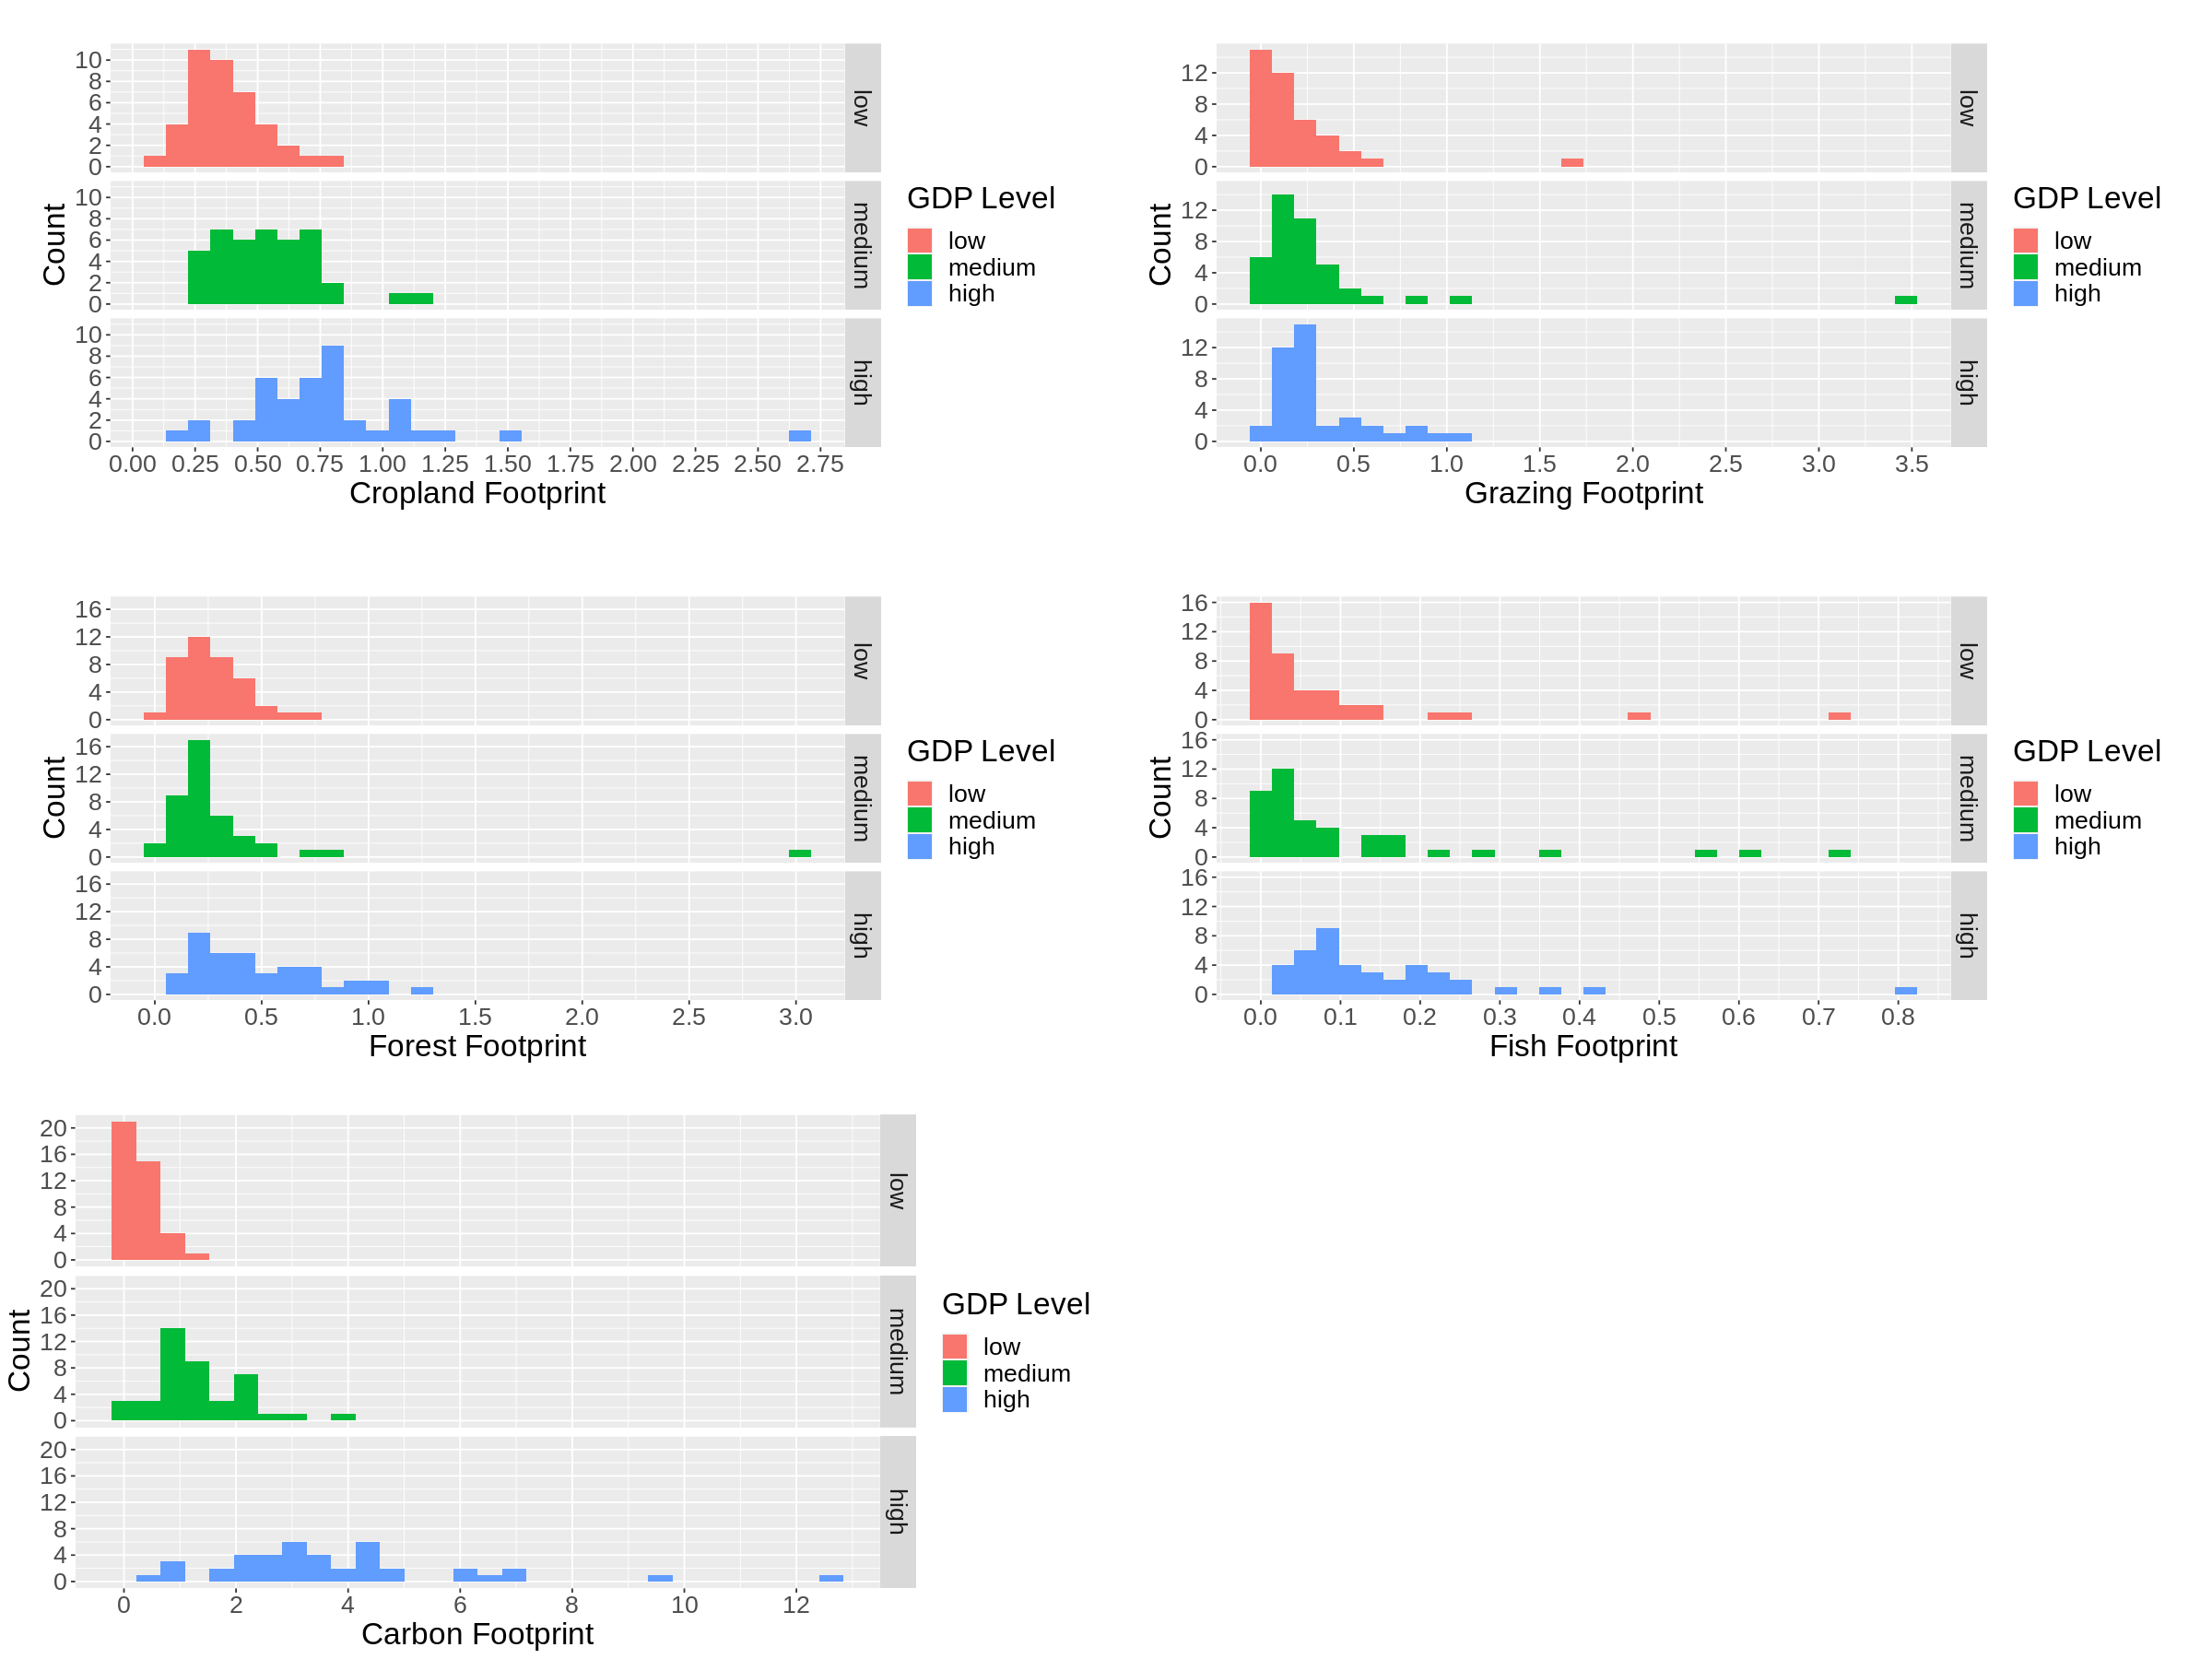

In [9]:
require(gridExtra)
options(repr.plot.height = 15, repr.plot.width = 20)

#creating histograms using only training set data, which compares the distributions of each predictor variable we plan to use 
#in our analysis. Colour coded by our created GDP categories to help identify any relationships between the distrutions and GDP level.

crop_visualization <- ggplot(countries_train, aes(x = cropland_footprint, fill = GDP_classified)) +
        geom_histogram() +
        labs(x = "Cropland Footprint", y = "Count", fill = "GDP Level") +
        theme(text = element_text(size = 20), plot.margin = unit(c(1,1,1,1), "cm")) +
        scale_x_continuous(breaks = seq(0, 3, by = 0.25)) +
        scale_y_continuous(breaks = seq(0, 20, by = 2)) +
        facet_grid(GDP_classified~.)

grazing_visualization <- ggplot(countries_train, aes(x = grazing_footprint, fill = GDP_classified)) +
        geom_histogram() +
        labs(x = "Grazing Footprint", y = "Count", fill = "GDP Level") +
        theme(text = element_text(size = 20), plot.margin = unit(c(1,1,1,1), "cm")) +
        scale_x_continuous(breaks = seq(0, 5, by = 0.5)) +
        scale_y_continuous(breaks = seq(0, 40, by = 4)) +
        facet_grid(GDP_classified~.)

forest_visualization <- ggplot(countries_train, aes(x = forest_footprint, fill = GDP_classified)) +
        geom_histogram() +
        labs(x = "Forest Footprint", y = "Count", fill = "GDP Level") +
        theme(text = element_text(size = 20), plot.margin = unit(c(1,1,1,1), "cm")) +
        scale_x_continuous(breaks = seq(0, 3, by = 0.5)) +
        scale_y_continuous(breaks = seq(0, 40, by = 4)) +
        facet_grid(GDP_classified~.)

fish_visualization <- ggplot(countries_train, aes(x = fish_footprint, fill = GDP_classified)) +
        geom_histogram() +
        labs(x = "Fish Footprint", y = "Count", fill = "GDP Level") +
        theme(text = element_text(size = 20), plot.margin = unit(c(1,1,1,1), "cm")) +
        scale_x_continuous(breaks = seq(0, 1, by = 0.1)) +
        scale_y_continuous(breaks = seq(0, 30, by = 4)) +
        facet_grid(GDP_classified~.)

carbon_visualization <- ggplot(countries_train, aes(x = carbon_footprint, fill = GDP_classified)) +
        geom_histogram() +
        labs(x = "Carbon Footprint", y = "Count", fill = "GDP Level") +
        theme(text = element_text(size = 20)) +
        scale_x_continuous(breaks = seq(0, 30, by = 2)) +
        scale_y_continuous(breaks = seq(0, 30, by = 4)) +
        facet_grid(GDP_classified~.)

#arranging our visualizations of each predictor variable into a grid for easy comparison
grid.arrange(crop_visualization, grazing_visualization, forest_visualization, fish_visualization, carbon_visualization)

<h4>Methods:

To answer our question (Are ecological assets a good predictor of a country’s GDP Per Capita?) we will be using the variables of cropland footprint, grazing footprint, forest footprint, and fish footprint. These variables are all ecological assets, and we will be using them as predictors when designing a classification model. Our classification model will be designed to classify a country's GDP level. We have subdivided GDP Per Capita in the raw data set into three evenly split categories: low, medium, and high. The accuracy of the classification model will tell us whether or not ecological assets (our predictors) are a good predictor of a country's GDP Per Capita.

We will visualize our results using 

<h4>Expected outcomes and significance:

We expect to find a postive relationship between the ecological footprint of a country and it’s GDP per capita. A positive relationship between those could indicate that countries that use more resources would have higher standards of living. Such a finding would mean that countries that want to develop their economy would have to use a lot of resources in order to have an economy which benefits its citizens. This could lead to questions regarding whether or not our way of living is sustainable. If resource demands are much higher than the sustainable supply, we may not have long until we run out of resources completely.